In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install EMD-signal
!apt-get install -y build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,  Dropout, BatchNormalization, Masking,Conv1D, MaxPooling1D,Bidirectional, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import scipy.signal as signal
from scipy.signal import savgol_filter
from PyEMD import CEEMDAN

In [ ]:
# 랜덤 시드 고정
tf.random.set_seed(2024)
np.random.seed(2024)

In [ ]:
plt.rc('font', family='NanumGothic')

In [ ]:
# 데이터 불러오기
data=pd.read_csv('도매지역별2_서울,광주처리.csv',encoding='utf-8')

In [ ]:
data=data.set_index('날짜')

In [ ]:
loc=['서울','광주','대전','부산','대구']

In [ ]:
data.head()

,총거래물량,도매지역,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),합계 일조시간(hr),합계 일사량(MJ/m2),일 최심신적설(cm),재배면적
날짜,,,,,,,,,,,,,,
2020-01-03,8322604.0,서울,2.652054,-1.152863,7.798667,0.000000,0.000000,4.514822,1.909097,64.363028,7.478393,5.438115,0.0,28941
2020-01-04,5243075.0,서울,2.213061,-2.263931,7.995609,0.012670,0.008523,4.730504,1.859670,63.722875,6.934945,5.269988,0.0,28941
2020-01-05,5464235.0,서울,2.461428,-3.098501,8.978610,0.034010,0.026705,2.998543,1.154877,59.174106,7.379017,5.966763,0.0,28941
2020-01-06,5685395.0,서울,4.486334,0.855391,6.658482,8.310125,8.954236,3.854252,1.646484,82.079009,0.007670,1.010279,0.0,28941
2020-01-07,3762942.0,서울,9.650072,5.806695,14.119640,11.625856,38.428220,7.498910,2.766200,95.378831,0.054688,0.679592,0.0,28941


In [ ]:
# 4차 버터워스 필터 함수 series-> series
def butterworth_filter_series(data_series, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normalized_cutoff, btype=filter_type, analog=False)
    filtered_data = signal.filtfilt(b, a, data_series.values)
    return pd.Series(filtered_data, index=data_series.index, name=data_series.name)
# 시계열로 만들어주는 함수
def create_sequences(features, target, time_steps):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)
# 사비츠키-골레이 함수 적용 필터 series-> series
def apply_savgol_filter_to_series(data_series, window_length=31, polyorder=2):
    # 시리즈 데이터를 넘파이 배열로 변환
    filtered_data = savgol_filter(data_series.values, window_length=window_length, polyorder=polyorder)

    # 원래 인덱스를 유지하며 시리즈로 반환
    return pd.Series(filtered_data, index=data_series.index, name=data_series.name)


In [ ]:
def lstm_set(data, 도매지역='광주',filter='None'):
    # 도매지역 필터링
    data = data[(data['도매지역'] == 도매지역)]
    data = data.drop(['도매지역'], axis=1)

    if filter=='butter':
      # Butterworth 필터 적용 (총거래물량)
      data['총거래물량'] = butterworth_filter_series(data['총거래물량'], cutoff=0.1, fs=1, order=4, filter_type='low')
    elif filter=='savgol':
      data['총거래물량']=apply_savgol_filter_to_series(data['총거래물량'])
    # 특성과 타겟 정의
    features = data[['평균기온(°C)','최저기온(°C)','최고기온(°C)','강수 계속시간(hr)','일강수량(mm)','최대 풍속(m/s)','평균 풍속(m/s)','평균 상대습도(%)','합계 일조시간(hr)','합계 일사량(MJ/m2)','일 최심신적설(cm)']].values
    target = data["총거래물량"].values

    # 스케일링 (Min-Max)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    target_scaled = scaler.fit_transform(target.reshape(-1, 1))

    # 시퀀스 생성
    time_steps = 80
    X, y = create_sequences(features_scaled, target_scaled, time_steps)

    # 데이터셋 분할 (훈련 70%, 테스트 30%)
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    # CNN-BiLSTM 모델 정의
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    # model.add(Bidirectional(LSTM(128, activation="relu", return_sequences=True)))
    model.add(LSTM(64, activation="relu", return_sequences=True))
    model.add(LSTM(32, activation="relu"))
    model.add(Dense(1))  # 출력 레이어
    model.compile(optimizer="adam", loss="mse")

    # 모델 학습
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # 모델 평가 및 예측
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # 결과를 원래 스케일로 역변환
    train_pred = scaler.inverse_transform(train_pred)
    y_train = scaler.inverse_transform(y_train)
    test_pred = scaler.inverse_transform(test_pred)
    y_test = scaler.inverse_transform(y_test)

    # 성능 평가
    mae = mean_absolute_error(y_test, test_pred)
    mse = mean_squared_error(y_test, test_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, test_pred)

    return y_train, train_pred, y_test, test_pred, mae, mse, rmse, r2


In [ ]:
m=['None','butter','savgol']

In [ ]:
# 필터별 결과
r={'None':{},'butter':{},'savgol':{}}
for i in m:
  for j in loc:
    r[i][j]=lstm_set(data,도매지역=j,filter=i)

<class 'numpy.ndarray'>
(1191, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0347 - val_loss: 0.0275
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0181 - val_loss: 0.0276
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0173 - val_loss: 0.0267
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0165 - val_loss: 0.0270
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0155 - val_loss: 0.0261
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0147 - val_loss: 0.0251
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0140 - val_loss: 0.0240
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0132 - val_loss: 0.0246
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0127 - val_loss: 0.0253
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0124 - val_loss: 0.0263
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0122 - val_loss: 0.0257
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0154 - val_loss: 0.0103
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0076 - val_loss: 0.0085
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0065 - val_loss: 0.0087
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0060 - val_loss: 0.0085
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0050 - val_loss: 0.0085
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0099 - val_loss: 0.0034
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0068 - val_loss: 0.0022
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0144 - val_loss: 0.0086
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0040 - val_loss: 0.0076
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0030 - val_loss: 0.0075
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0030 - val_loss: 0.0076
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 9.7730e-04 - val_loss: 0.0014
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.0443e-04 - val_loss: 0.0014
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 8.4373e-04 - val_loss: 0.0014
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 7.8463e-04 - val_loss: 0.0014
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 7.4438e-04 - val_loss: 0.0014
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7.3168e-04 - val_loss: 0.0014
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.6636e-04 - val_loss: 0.0015
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 6.2603e-04 - val_loss: 0.0015
Epoch 12/100
75/75 ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0288 - val_loss: 0.0242
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0095 - val_loss: 0.0252
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0094 - val_loss: 0.0265
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0084 - val_loss: 0.0262
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0063 - val_loss: 0.0221
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0051 - val_loss: 0.0225
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0039 - val_loss: 0.0226
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0035 - val_loss: 0.0223
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0035 - val_loss: 0.0242
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0041 - val_loss: 0.0235
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0036 - val_loss: 0.0246
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0074 - val_loss: 0.0115
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0072 - val_loss: 0.0111
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0060 - val_loss: 0.0108
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0039 - val_loss: 0.0103
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0035 - val_loss: 0.0092
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0025 - val_loss: 0.0090
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0019 - val_loss: 0.0092
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0017 - val_loss: 0.0090
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0014 - val_loss: 0.0067
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0095 - val_loss: 0.0063
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0038 - val_loss: 0.0064
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0028 - val_loss: 0.0058
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 9.0971e-04 - val_loss: 0.0061
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 8.3827e-04 - val_loss: 0.0062
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 8.1100e-04 - val_loss: 0.0018
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7.6998e-04 - val_loss: 0.0017
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 6.9282e-04 - val_loss: 0.0015
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5.9153e-04 - val_loss: 0.0013
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 5.0212e-04 - val_loss: 0.0012
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.8307e-04 - val_loss: 0.0012
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 2.5281e-04 - val_loss: 0.0012
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1.9720e-04 - val_loss: 0.0013
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.3893e-04 - val_loss: 0.0013
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1.0558e-04 - val_loss: 0.0013
Epoch 12/100
75/75 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0213 - val_loss: 0.0251
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0088 - val_loss: 0.0255
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0073 - val_loss: 0.0258
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0060 - val_loss: 0.0241
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0045 - val_loss: 0.0232
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0027 - val_loss: 0.0224
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0017 - val_loss: 0.0215
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0014 - val_loss: 0.0218
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0013 - val_loss: 0.0223
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0012 - val_loss: 0.0223
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 8.1178e-04 - val_loss: 0.0228
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0061 - val_loss: 0.0100
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0049 - val_loss: 0.0102
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0042 - val_loss: 0.0102
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0019 - val_loss: 0.0086
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0010 - val_loss: 0.0088
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7.8277e-04 - val_loss: 0.0085
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 6.2712e-04 - val_loss: 0.0087
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 4.7221e-04 - val_loss: 0.0090
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.6202e-04 - val_loss: 0.0093
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0010 - val_loss: 0.0026
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
16/16 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0112 - val_loss: 0.0061
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.9819e-04 - val_loss: 0.0055
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.3318e-04 - val_loss: 0.0055
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 2.7770e-04 - val_loss: 0.0054
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.9152e-04 - val_loss: 0.0054
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.1876e-04 - val_loss: 0.0054
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 3

In [ ]:
# 지역별 결과
r={}
for i in loc:
  r[i]=lstm_set(data,도매지역=i,filter='savgol')

<class 'numpy.ndarray'>
(1191, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0283 - val_loss: 0.0132
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0153 - val_loss: 0.0098
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0115 - val_loss: 0.0056
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0053 - val_loss: 0.0073
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0044 - val_loss: 0.0076
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0037 - val_loss: 0.0075
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0034 - val_loss: 0.0075
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0029 - val_loss: 0.0082
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0271 - val_loss: 0.0184
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0138 - val_loss: 0.0171
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0138 - val_loss: 0.0196
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0076 - val_loss: 0.0229
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0051 - val_loss: 0.0233
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0040 - val_loss: 0.0304
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0034 - val_loss: 0.0234
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0029 - val_loss: 0.0204
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0021 - val_loss: 0.0156
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0026 - val_loss: 0.0156
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0021 - val_loss: 0.0177
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0287 - val_loss: 0.0142
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0147 - val_loss: 0.0100
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0135 - val_loss: 0.0093
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0072 - val_loss: 0.0101
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0047 - val_loss: 0.0097
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0038 - val_loss: 0.0103
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0030 - val_loss: 0.0080
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0025 - val_loss: 0.0095
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0014 - val_loss: 0.0083
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0187 - val_loss: 0.0027
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0131 - val_loss: 0.0035
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0099 - val_loss: 0.0037
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0102 - val_loss: 0.0035
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0080 - val_loss: 0.0036
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0107 - val_loss: 0.0024
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0099 - val_loss: 0.0039
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0309 - val_loss: 0.0185
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0184 - val_loss: 0.0153
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0082 - val_loss: 0.0128
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0041 - val_loss: 0.0117
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0033 - val_loss: 0.0100
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0029 - val_loss: 0.0096
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0019 - val_loss: 0.0118
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0024 - val_loss: 0.0114
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0017 - val_loss: 0.0116
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0

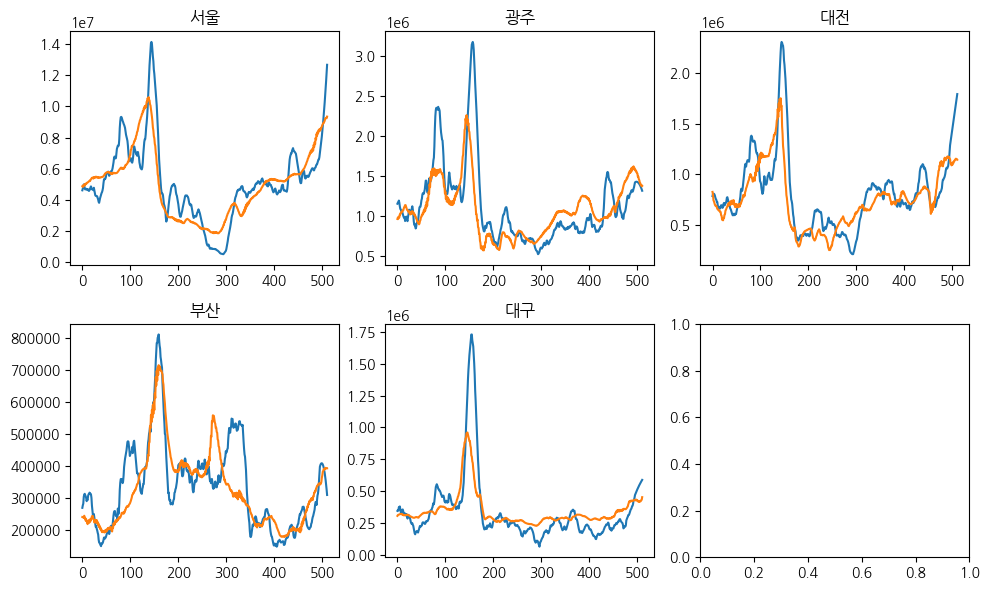

,mae,mse,rmse,r2
서울,1.122320e+06,2.045285e+12,1.430135e+06,0.678583
광주,2.382842e+05,1.289276e+11,3.590650e+05,0.460030
대전,1.745652e+05,6.027418e+10,2.455080e+05,0.580234
부산,6.324576e+04,7.764306e+09,8.811530e+04,0.575536
대구,1.035659e+05,3.170483e+10,1.780585e+05,0.570185


In [ ]:
# 그래프 그리고 결과 출력
fig, axes = plt.subplots(2,3, figsize=(10, 6))

# 각 컬럼을 반복하면서 서브플롯에 그래프 그리기
for i, l in zip(range(5),loc):
    ax = axes.flat[i]
    ax.plot(r[l][2], label='Actual')
    ax.plot(r[l][3], label='Predicted')
    ax.set_title(l)
# 레이아웃 조정
plt.tight_layout()
plt.show()

rl=[]
for i in loc:
  rl.append(r[i][4:])
fin=pd.DataFrame(rl,columns=['mae','mse','rmse','r2'],index=loc)
fin

In [ ]:
sav=r

In [ ]:
# csv로 저장
a=pd.Series(np.concatenate([sav['광주'][1], sav['광주'][3]], axis=0).reshape(-1),index=data[data['도매지역']=='광주'].index[80:])
b=data[data['도매지역']=='광주'][['총거래물량','도매지역']].iloc[80:,:]
광주=pd.concat([b,a],axis=1)
광주=광주.drop('도매지역',axis=1)
광주.columns=['총거래물량','총거래물량_예측']
광주.to_csv('광주.csv',encoding='utf-8')

In [ ]:
서울.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1702 entries, 2020-03-23 to 2024-11-18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   총거래물량     1702 non-null   float64
 1   총거래물량_예측  1702 non-null   float32
dtypes: float32(1), float64(1)
memory usage: 33.2+ KB
